# Fully-connected autoencoders

**Train an autoencoder on MNIST dataset**

tasks (all using fc layer in encoder / decoder part):


*   linear autoencoder
    *   MSE results on test data
    *   visualizatoin of weights (first fc layer) 

*   non-linear autoencoder
   *   MSE results on test data
   *   visualization of weights (first fc layer)

*   sparse autoencoder
    *   MSE results on test data
    *   visualization of weights (first fc layer)






In [ ]:
####### importing python packages ######
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image 
import matplotlib.pyplot as plt
import numpy as np

# make dir to save images
if not os.path.exists('./in_out_img'):
    os.mkdir('./in_out_img')

**training configs (user defined)**      
**please adjust the training hyperparameters and architectures in this part**

In [ ]:
###### training configs -- user defined ######
num_epochs = 100
batch_size = 128
learning_rate = 1e-3
momentum = 0.9          # momentum
weight_decay =1e-5      # weight decay

arch = 'linear_AE'   # 'nonlinear_AE' | 'linear_AE' | 'sparse_AE' 
sparse_reg  =  1e-3   #  regulaization coefficient
best_val = float('inf')     # record the best val loss
# test

**models (nonlinear_AE  |  linear_AE  |  sparse_AE)** 

In [ ]:
# define the non-linear autoencoder  128 -- 64 -- 16 -- 64 -- 128
class nonlinear_AE(nn.Module):
    def __init__(self):
        super(nonlinear_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 32), 
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# define the linear autoencoder  128 -- 64 -- 16 -- 64 -- 128
class linear_AE(nn.Module):
    def __init__(self):
        super(linear_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            # nn.ReLU(True),
            nn.Linear(128, 64),
            # nn.ReLU(True), 
            nn.Linear(64, 32), 
            # nn.ReLU(True)
            )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            # nn.ReLU(True),
            nn.Linear(64, 128),
            # nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            # nn.Tanh()
            )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class sparse_AE(nn.Module):
    def __init__(self):
        super(sparse_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# define the sparse loss, here using mean absolute error (L1 loss)
def sparse_loss(autoencoder, inputs):
    loss = 0
    out = inputs
    for i in range(3):  # encoder layers constraining on the activations
        fc_layer = list(autoencoder.encoder.children())[2 * i]  # 0, 2, 4
        relu = list(autoencoder.encoder.children())[2 * i + 1]
        out = relu(fc_layer(out))
        loss += torch.mean(torch.abs(out))
    for i in range(2):  # decoder layers (without the last fc layer) constraining on the activations
        fc_layer = list(autoencoder.decoder.children())[2 * i]
        relu = list(autoencoder.decoder.children())[2 * i + 1]
        out = relu(fc_layer(out))
        loss += torch.mean(torch.abs(out))
    return loss

**define the evaluation**

In [ ]:
def evaluation(model, test_loader, epoch):
    total_loss = 0
    recons_loss = nn.MSELoss()
    model.eval()
    for batch_idx, (img, _) in enumerate(test_loader):
        img = img.view(img.size(0), -1)
        img = Variable(img.cuda())
        out = model(img)
        loss = recons_loss(out, img)
        total_loss += loss * img.size(0)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))
    if epoch % 10 == 0:
        # save input/output images
        pic = to_img(img.cpu().data)
        save_image(pic, './in_out_img/input_{}.png'.format(epoch))
        pic = to_img(out.cpu().data)
        save_image(pic, './in_out_img/recons_{}.png'.format(epoch))
    # save the best model with lowest mse loss    
    global best_val
    if avg_loss < best_val:
        best_val = avg_loss
        torch.save(model.state_dict(), './' + arch + '_best.pth')
    print('Saved Best Model\n')

**start training (use Adam optimizer)**

In [ ]:
# coder credits: https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py
# fix random seed for reproducible results
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


# define method to save output images 
def to_img(x):
    x = 0.5 * (x + 1)   # Tanh activation squashes the output to range [-1, 1] 
    x = x.clamp(0, 1)   
    x = x.view(x.size(0), 1, 28, 28)    # reshae the vectorized output to grayscale images
    return x

# define the transformation applied to MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train/test loader
train_loader = DataLoader(MNIST('./data', train=True, download=True, 
                          transform=transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MNIST('./data', train=False, 
                          transform=transform), batch_size=batch_size, shuffle=False)


if arch == 'nonlinear_AE':  
    model = nonlinear_AE().cuda()
    # model.load_state_dict(torch.load('./.pth'))
elif arch == 'linear_AE':
    model = linear_AE().cuda()
elif arch == 'sparse_AE':
    model = sparse_AE().cuda()

print('training {} model'.format(arch))

# use Mean Squared Error loss for reconstruction
recons_loss = nn.MSELoss()

# define the optimizer
# optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
print('Adam optimizer')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    model.train()     # train mode
    #  no use of labels
    for batch_idx, (img, _) in enumerate(train_loader):
        # show the first image in the 'batch_id'-th batch
        # plt.imshow((data[0].numpy().copy().squeeze(0)), cmap='gray')
        # strech images into column vectors
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        # output reconstructed images
        out = model(img)
        
        if arch == 'sparse_AE':  # if sparse autoencoder, use MSE loss and L1 loss
            l1_loss = sparse_loss(model, img)
            mse_loss = recons_loss(out, img)
            loss = mse_loss + sparse_reg * l1_loss
        else: # compute the MSE loss for models w/o regularization
            loss = recons_loss(out, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        if (batch_idx + 1) % 100 == 0:
            if arch == 'sparse_AE':
                print('Epoch [{}/{}] - Iter[{}/{}], Total loss:{:.4f}, MSE loss:{:.4f}, Sparse loss:{:.4f}'.format(
                    epoch + 1, num_epochs, batch_idx + 1, len(train_loader.dataset) // batch_size, loss.item(), mse_loss.item(), l1_loss.item()))
            else:
                print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.4f}'.format(
                    epoch + 1, num_epochs, batch_idx + 1, len(train_loader.dataset) // batch_size, loss.item()))
    # evaluation on test set
    evaluation(model, test_loader, epoch)
    # ===================log========================
    # print('epoch [{}/{}], MSE loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    
# save the model to file
torch.save(model.state_dict(), './' + arch + '_final.pth')

0it [00:00, ?it/s]

9920512it [00:01, 8839318.71it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135510.24it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2476199.08it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51793.47it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
training linear_AE model
Adam optimizer
Epoch [1/100] - Iter[100/468], MSE loss:0.1579
Epoch [1/100] - Iter[200/468], MSE loss:0.1153
Epoch [1/100] - Iter[300/468], MSE loss:0.0986
Epoch [1/100] - Iter[400/468], MSE loss:0.0897

Average MSE Loss on Test set: 0.0834
Saved Best Model

Epoch [2/100] - Iter[100/468], MSE loss:0.0762
Epoch [2/100] - Iter[200/468], MSE loss:0.0756
Epoch [2/100] - Iter[300/468], MSE loss:0.0743
Epoch [2/100] - Iter[400/468], MSE loss:0.0716

Average MSE Loss on Test set: 0.0699
Saved Best Model

Epoch [3/100] - Iter[100/468], MSE loss:0.0749
Epoch [3/100] - Iter[200/468], MSE loss:0.0731
Epoch [3/100] - Iter[300/468], MSE loss:0.0705
Epoch [3/100] - Iter[400/468], MSE loss:0.0726

Average MSE Loss on Test set: 0.0697
Saved Best Model

Epoch [4/100] - Iter[100/468], MSE loss:0.0675
Epoch [4/100] - Iter[200/468], MSE loss:0.0720
Epoch [4/100] - Iter[300/468], MSE loss:0.0698
Epoch [4/100]

##Visualization of learned filters

**when the training is done, visualize the weights of the first layer**


In [ ]:
print('visualizing ' + arch)

model = torch.load('./' + arch + '_best.pth')

model_weights = model['encoder.2.weight'].cpu()      # w/o bias

if arch != 'conv_AE':
    model_weights = model_weights.view(model_weights.shape[0], 1, 8, 8)  

torch_scale = lambda x: (x - torch.min(x)) / (torch.max(x) - torch.min(x))
model_weights_norm = torch_scale(model_weights)

plt.figure(figsize=(12, 6))
plt.title(arch)
plt.imshow(np.transpose(torchvision.utils.make_grid(model_weights_norm).numpy(), (1, 2, 0)))
plt.axis('off')
plt.savefig(arch + '_filt.png')
plt.close('all')
print('figure saved')

visualizing linear_AE
figure saved


#Learning specific structure

##Sparse autoencoders

#Applications

##Denoising autoencoders

**define the evaluation**

In [ ]:
def evaluation(model, test_loader, epoch):
    total_loss = 0
    recons_loss = nn.MSELoss()
    model.eval()
    for batch_idx, (img, _) in enumerate(test_loader):
        if arch != 'conv_AE':
            img = img.view(img.size(0), -1)
        
        if arch == 'denoise_AE':
            noise_img = img * (1 - noise_ratio) + torch.rand(img.size()) * noise_ratio      # add noise onto input images
            noise_img = Variable(noise_img.cuda())
            img = Variable(img.cuda())
            out = model(noise_img)
        else:
            img = Variable(img.cuda())
            out = model(img)
        loss = recons_loss(out, img)
        total_loss += loss * img.size(0)
    avg_loss = total_loss / len(test_loader.dataset)

    print('\nAverage MSE Loss on Test set: {:.4f}'.format(avg_loss))
    if epoch % 10 == 0:
        # save input/output images
        if arch == 'denoise_AE':
            pic = to_img(noise_img.cpu().data)
            save_image(pic, './in_out_img/noise_input_{}.png'.format(epoch))
        pic = to_img(img.cpu().data)
        save_image(pic, './in_out_img/input_{}.png'.format(epoch))
        pic = to_img(out.cpu().data)
        save_image(pic, './in_out_img/recons_{}.png'.format(epoch))
    # save the best model with lowest mse loss    
    global best_val
    if avg_loss < best_val:
        best_val = avg_loss
        torch.save(model.state_dict(), './' + arch + '_best.pth')
    print('Saved Best Model\n')

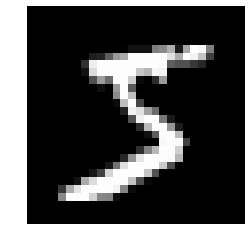

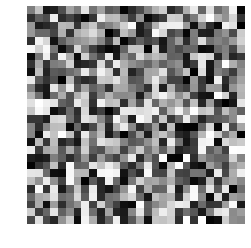

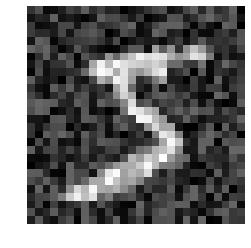

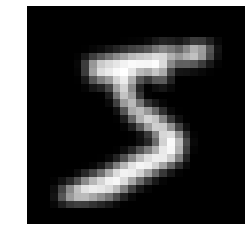

In [ ]:
import matplotlib.pyplot as plt
import gzip
import pickle
from PIL import Image
import cv2
dataset = MNIST('./data', train=True, download=True,transform=None)
# fix random seed for reproducible results
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# 
filename = [
["training_images","./data/MNIST/raw/train-images-idx3-ubyte.gz"],
["test_images","./data/MNIST/raw/t10k-images-idx3-ubyte.gz"],
["training_labels","./data/MNIST/raw/train-labels-idx1-ubyte.gz"],
["test_labels","./data/MNIST/raw/t10k-labels-idx1-ubyte.gz"]
]

# load downloaded .gz files to and save images as numpy arrays 
def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    # for name in filename[-2:]:
    #     with gzip.open(name[1], 'rb') as f:
    #         mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

# save_mnist()

with open("mnist.pkl",'rb') as f:
    mnist = pickle.load(f)
    mnist_train_X = mnist["training_images"]  # 60000, 784
    mnist_train_X = mnist["test_images"]  # 10000, 784

# TODO: define idx
idx = 0
img = mnist_train_X[idx].reshape(28,28)  / 255.

plt.figure()
plt.imshow(img, cmap='gray')
plt.axis('off')


Image.fromarray(img).convert("L").save("clean_input.jpg")
# plt.savefig('clean_input.png')

noise = torch.rand(torch.Size([28, 28])).numpy()
plt.figure()
plt.imshow(noise,cmap='gray')
plt.axis('off')
Image.fromarray(noise).convert("L").save("clean_input.jpg")
# plt.savefig('rand_noise.png')

corrupt_img = img * (1 - noise_ratio) + noise * noise_ratio 
plt.figure()
plt.imshow(corrupt_img,cmap='gray')
plt.axis('off')
Image.fromarray(corrupt_img).convert("L").save("clean_input.jpg")
# plt.savefig('corrupt_input.png')


blurry_img = cv2.GaussianBlur(img,(3,3),0)
plt.figure()
plt.imshow(blurry_img,cmap='gray')
plt.axis('off')
plt.savefig('blurry_out.png')

**start training**

In [ ]:

# fix random seed for reproducible results
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


# define method to save output images 
def to_img(x):
    x = 0.5 * (x + 1)   # Tanh activation squashes the output to range [-1, 1] 
    x = x.clamp(0, 1)   
    x = x.view(x.size(0), 1, 28, 28)    # reshae the vectorized output to grayscale images
    return x

# define the transformation applied to MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# train/test loader
train_loader = DataLoader(MNIST('./data', train=True, download=True, 
                          transform=transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MNIST('./data', train=False, 
                          transform=transform), batch_size=batch_size, shuffle=False)


if arch == 'nonlinear_AE':  
    model = nonlinear_AE().cuda()
    # model.load_state_dict(torch.load('./.pth'))
elif arch == 'linear_AE':
    model = linear_AE().cuda()
elif arch == 'sparse_AE':
    model = sparse_AE().cuda()
elif arch == 'conv_AE':
    model = conv_AE().cuda()
##TODO: denoising autoencoders    
elif arch == 'denoise_AE':
    model = linear_AE().cuda()
print('training {} model'.format(arch))

# use Mean Squared Error loss for reconstruction
recons_loss = nn.MSELoss()

# define the optimizer
# optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
print('Adam optimizer')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    model.train()     # train mode
    #  no use of labels
    for batch_idx, (img, _) in enumerate(train_loader):
        # show the first image in the 'batch_id'-th batch
        # plt.imshow((data[0].numpy().copy().squeeze(0)), cmap='gray')
        if arch != 'conv_AE':
            # strech images into column vectors if not training convolutional AE
            img = img.view(img.size(0), -1)
        # ===================forward=====================
        # output reconstructed images
        if arch == 'denoise_AE':
            noise_img = img * (1 - noise_ratio) + torch.rand(img.size()) * noise_ratio      # add noise onto input images
            noise_img = Variable(noise_img.cuda())
            img = Variable(img).cuda()
            out = model(noise_img)
        else:
            img = Variable(img).cuda()
            out = model(img)
        
        if arch == 'sparse_AE':  # if sparse autoencoder, use MSE loss and L1 loss
            l1_loss = sparse_loss(model, img)
            mse_loss = recons_loss(out, img)
            loss = mse_loss + sparse_reg * l1_loss
        else: # compute the MSE loss for models w/o regularization
            loss = recons_loss(out, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # ===================log========================
        if (batch_idx + 1) % 100 == 0:
            if arch == 'sparse_AE':
                print('Epoch [{}/{}] - Iter[{}/{}], Total loss:{:.4f}, MSE loss:{:.4f}, Sparse loss:{:.4f}'.format(
                    epoch + 1, num_epochs, batch_idx + 1, len(train_loader.dataset) // batch_size, loss.item(), mse_loss.item(), l1_loss.item()))
            else:
                print('Epoch [{}/{}] - Iter[{}/{}], MSE loss:{:.4f}'.format(
                    epoch + 1, num_epochs, batch_idx + 1, len(train_loader.dataset) // batch_size, loss.item()))
    # evaluation on test set
    evaluation(model, test_loader, epoch)
    # ===================log========================
    # print('epoch [{}/{}], MSE loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    
# save the model to file
torch.save(model.state_dict(), './' + arch + '_final.pth')

0it [00:00, ?it/s]

9920512it [00:01, 9560760.33it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 137156.00it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2200155.31it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 53176.51it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
training denoise_AE model
Adam optimizer
Epoch [1/100] - Iter[100/468], MSE loss:0.1666
Epoch [1/100] - Iter[200/468], MSE loss:0.1267
Epoch [1/100] - Iter[300/468], MSE loss:0.1089
Epoch [1/100] - Iter[400/468], MSE loss:0.0973

Average MSE Loss on Test set: 0.0924
Saved Best Model

Epoch [2/100] - Iter[100/468], MSE loss:0.0933
Epoch [2/100] - Iter[200/468], MSE loss:0.0845
Epoch [2/100] - Iter[300/468], MSE loss:0.0809
Epoch [2/100] - Iter[400/468], MSE loss:0.0805

Average MSE Loss on Test set: 0.0751
Saved Best Model

Epoch [3/100] - Iter[100/468], MSE loss:0.0718
Epoch [3/100] - Iter[200/468], MSE loss:0.0728
Epoch [3/100] - Iter[300/468], MSE loss:0.0744
Epoch [3/100] - Iter[400/468], MSE loss:0.0730

Average MSE Loss on Test set: 0.0713
Saved Best Model

Epoch [4/100] - Iter[100/468], MSE loss:0.0737
Epoch [4/100] - Iter[200/468], MSE loss:0.0721
Epoch [4/100] - Iter[300/468], MSE loss

##Variational autoencoders

#Covolutional autoencoders